In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import time

np.set_printoptions(suppress=True)
path = '/Users/tae/Desktop/Project/Dataset/normalize/Normalize6_avg.xlsx'
size_feature = 6
size_row = 4
sizerespose = 3

In [17]:
def n_fold():
    
#     print('Function : n_fold ✅')
    data = pd.read_excel(path)
    print(data)

    
    dc1 = data[data['class']== 1]
    dc2 = data[data['class']== 2]
    dc3 = data[data['class']== 3]
    dc4 = data[data['class']== 4]

    a1 = len(dc1) // 10-1
    a2 = len(dc2) // 10-1
    a3 = len(dc3) // 10-1
    a4 = len(dc4) // 10-1

        

    train = np.empty(10 , dtype='object')
    test = np.empty(10 , dtype='object')

    for cj in range(1,11):
        
        if cj == 10:
            
            stdc1 = (cj-1) * (a1+1)
            ftdc1 = len(dc1)
            
            stdc2 = (cj-1) * (a2+1)
            ftdc2 = len(dc2)
            
            stdc3 = (cj-1) * (a3+1);
            ftdc3 = len(dc3)
            
            stdc4= (cj-1) * (a4+1);
            ftdc4 = len(dc4)
            
        else:
            stdc1 = (cj-1) * (a1+1)
            ftdc1 = stdc1+a1
            
            stdc2 = (cj-1) * (a2+1)
            ftdc2 = stdc2+a2
            
            stdc3 = (cj-1) * (a3+1)
            ftdc3 = stdc3+a3
            
            stdc4 = (cj-1) * (a4+1)
            ftdc4 = stdc4+a4
            
        Dtest1 = dc1[stdc1:ftdc1+1]
        Dtest2 = dc2[stdc2:ftdc2+1]
        Dtest3 = dc3[stdc3:ftdc3+1]
        Dtest4 = dc4[stdc4:ftdc4+1]

        Dtrain1 = dc1.drop(dc1.index[stdc1:ftdc1+1])
        Dtrain2 = dc2.drop(dc2.index[stdc2:ftdc2+1])
        Dtrain3 = dc3.drop(dc3.index[stdc3:ftdc3+1])
        Dtrain4 = dc4.drop(dc4.index[stdc4:ftdc4+1])
        
        
      


        #test[cj-1] = pd.concat([Dtest4,Dtest3,Dtest2,Dtest1],ignore_index=True).to_numpy()
        test[cj-1] = pd.concat([Dtest1,Dtest2 , Dtest3 , Dtest4],ignore_index=True).to_numpy()
        train[cj-1] = pd.concat([Dtrain1, Dtrain2, Dtrain3 ,Dtest4], ignore_index=True).to_numpy()

    return train , test
    

In [18]:
def initial_pop(size=10):
    
    c_whale = np.empty(size , dtype='object')
    for i in range(size):
        c_whale[i] = np.random.random(size=(size_row,size_feature))
        
    return c_whale


In [19]:
def evaluate_fitness(population, data_train):

    perform = []

    for i in range(len(population)):
        count = 0
        wp = population[i]
        
        for j in range(len(data_train)):
            clone_data = np.tile( data_train[j ,:size_feature] , (size_row,1))
            dis = np.sqrt( np.sum((clone_data - wp)**2 , axis=1)  )
            min_index = np.argmin(dis)
            
            if min_index+1 == data_train[j , size_feature : size_feature+1]:
                count = count + 1
        perform.append((i, count))
                
    score = np.array(perform)
    gbest = population[np.argmax(score[:,1])]
        
    return  score , gbest
    

In [20]:
def sort_value(score):
  
    index = np.argsort(score[:, 1])[::-1]
    top_ten = score[index][:10]
    max_fit = score[index][0, 1]
    indexs = index[:10]

    return  top_ten , max_fit , indexs

In [21]:
def test_model(model , dataTest):
    only_data = dataTest[:,:size_feature]
    class_data = dataTest[:,size_feature:size_feature+1]
    count = 0
    
    for i in range(len(dataTest)):
        md = np.tile(only_data[i] , (size_row,1))
        dis = np.sqrt( np.sum((model - md)**2 , axis=1) )

        
        if np.argmin(dis)+1 == class_data[i]:
            count = count+1
    
    return count

In [26]:
def train_model(population , gbest , train):
    
 
    best_value = []
    max_iter = 100
    pxi = 0.5
    imax_fit = 0
    
    repeat = 0
    count = 0
    threshold = 0.1 * max_iter
#     threshold = 3
    
     
    
    for i in range(1 , max_iter+1): 
        
        a =  2 + (-2 * (i/max_iter)) 
        r = np.random.random(size=(size_row, size_feature))
        l = (a - 1) * r + 1
        A = ((2 * a )* r) - a
        C = 2 * r
        
        
        if repeat >=900:
                break
        
        new_population = np.empty(10, dtype='object')
        
        for j in range(len(population)):
            w_pop = population[j]
            
            if np.random.random() < pxi:
                
                if np.abs(np.sum(A)) < 1:
                    w_rand = np.random.choice(population)
                    D_x = np.sqrt( np.sum( ( (C * w_rand) - w_pop)**2, axis=1  ) ).reshape(size_row,1)                    
                    wpop = w_rand - (A * D_x)

                    
                else:
                    D_x = np.sqrt( np.sum( ( (C * gbest) - w_pop)**2, axis=1  ) ).reshape(size_row,1)
                    wpop = gbest - (A * D_x)
                    
            else:
                w_dist = np.sqrt( np.sum((gbest - w_pop)**2, axis=1 )).reshape(size_row,1)
                wpop = (w_dist * np.exp(l) * np.cos(l * 2 * np.pi)) + gbest 
                
            new_population[j] = np.clip(wpop , a_min=0 , a_max=1) 
        
         # Combined old+new
        combined = np.concatenate((population, new_population))
        score, gbest = evaluate_fitness(combined,train)
        
        #sort data (Fn)
        top_ten , max_fit , new_index = sort_value(score)
        
        #replace population
        population = combined[new_index]
        best_value.append((i,  max_fit))
        
        if imax_fit == max_fit:
            count = count + 1
        else:
            imax_fit = max_fit
            count = 0
           
        
        #Check Threshold 
        
        if count > threshold  :
            count = 0
            repeat = repeat + 1
           

            for x in range(1,len(population)):
                if x in {1,2,3}:
                    newW = (0.1 * np.random.random(size=(size_row,size_feature))) - 0.05
                    population[x] = population[0] + newW
                else:
                    population[x] = np.random.random(size=(size_row,size_feature))
        
                    
                    
                    

                    
    index , value = zip(*best_value)
    plt.figure(figsize=(18,6))
    plt.plot(index,value, marker='o', markersize=2, linewidth=0.8)
    plt.show()

      
        
    return population[-1] , best_value[-1][0], best_value[-1][1] , max_iter , best_value

60

In [27]:
def execute(train,test):
    
    performance = []
    iterValue = []
    graph = []
        
    for i in range(len(test)):

        test_size = len(test[i])
        # 1. initial whale
        population = initial_pop()
        # 2.fitness
        score,gbest = evaluate_fitness(population , train[i])
        # 3.train
        model, lastIter, lastValue, max_iter , best_value = train_model(population,gbest,train[i])
        # 4.test
        
        score_model = test_model(model,test[i])
        graph.append((best_value))
        performance.append([test_size, score_model , np.round(score_model / test_size ,5)])
        iterValue.append([len(train[i]),lastIter,lastValue])
    
    return  np.array(performance), np.array(iterValue) , graph


            x1        x2        x3        x4        x5        x6  class
0     0.609365  0.530146  0.373013  0.633097  0.624433  0.447552      1
1     0.663063  0.502780  0.607898  0.610838  0.654355  0.694019      1
2     0.643300  0.515310  0.446110  0.667592  0.500599  0.535364      1
3     0.566713  0.505600  0.501322  0.576670  0.666412  0.556325      1
4     0.551703  0.530857  0.492900  0.716726  0.735216  0.589239      1
...        ...       ...       ...       ...       ...       ...    ...
4057  0.431849  0.391650  0.537681  0.441482  0.504861  0.609230      4
4058  0.245440  0.358346  0.551924  0.307443  0.513636  0.446452      4
4059  0.455762  0.511177  0.504899  0.268802  0.350782  0.516088      4
4060  0.373318  0.364169  0.645297  0.359496  0.499079  0.425776      4
4061  0.308600  0.286592  0.353429  0.589564  0.547656  0.583493      4

[4062 rows x 7 columns]


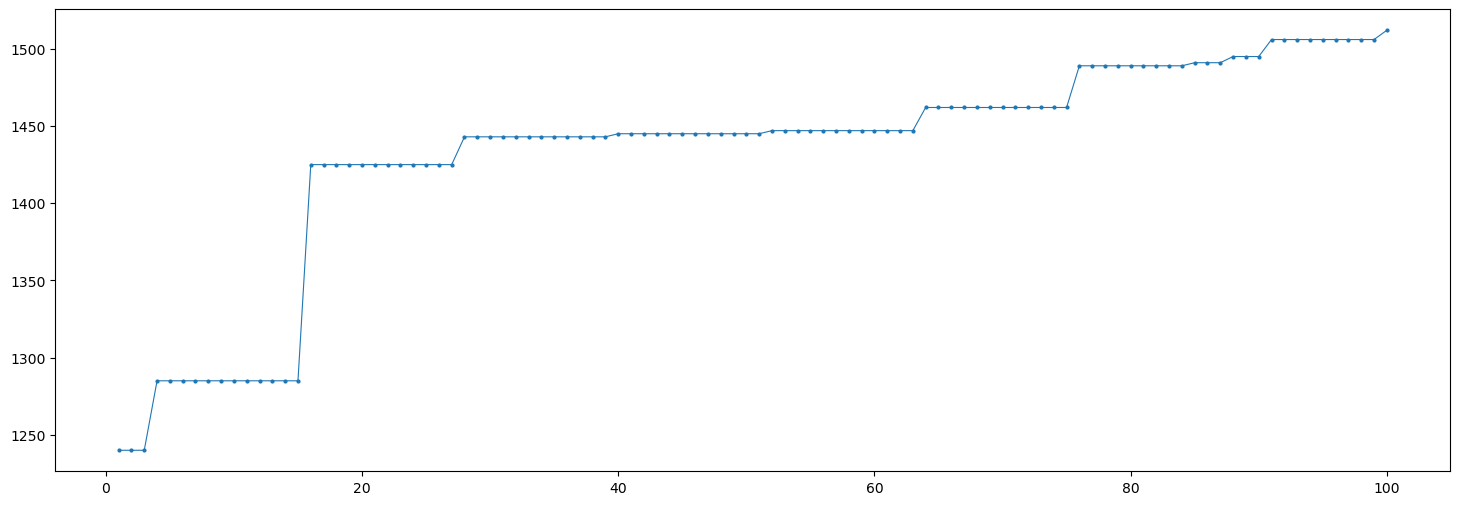

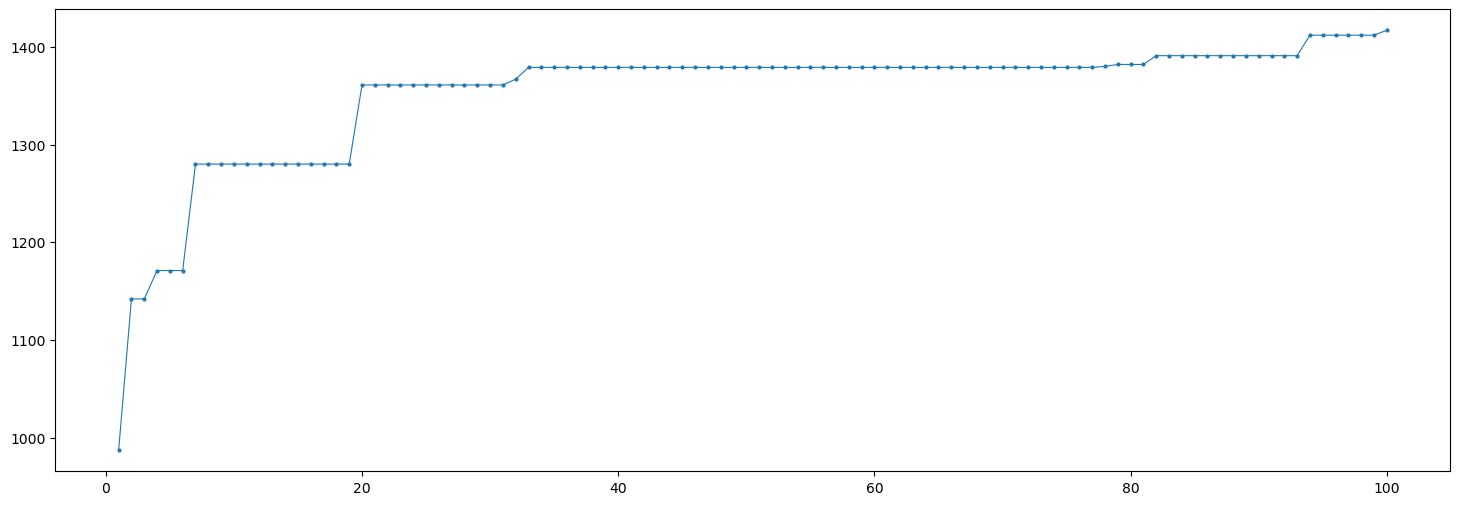

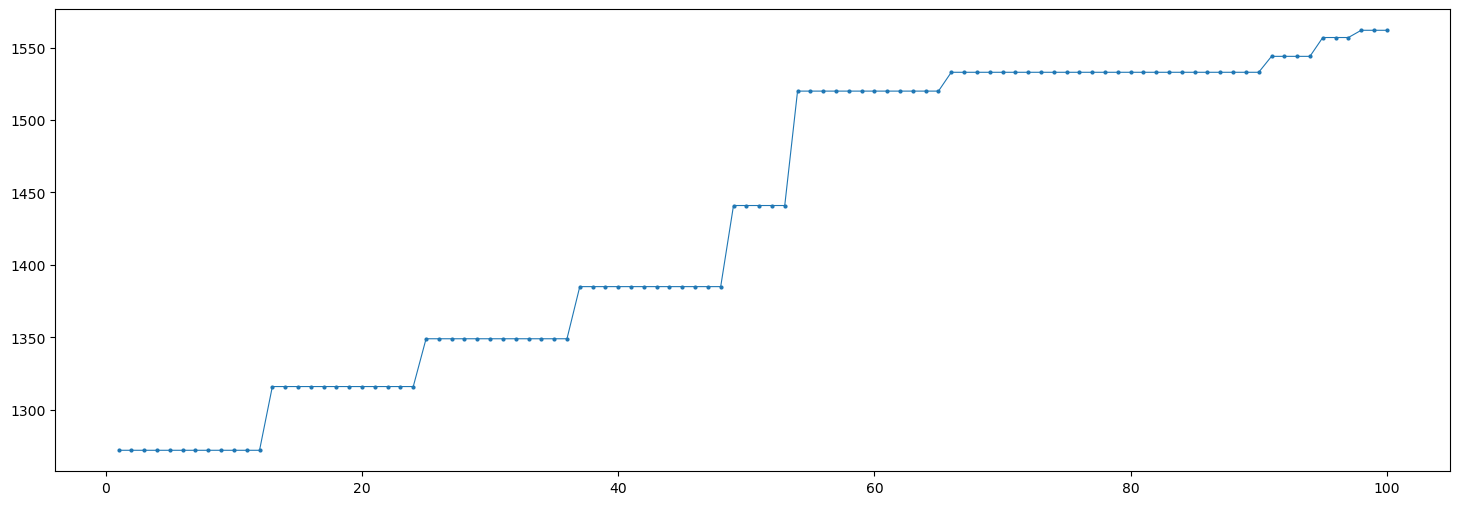

In [28]:
train , test = n_fold()
perform , value , graph = execute(train[:3] , test[:3])

In [29]:
print('score test: ',perform)
print('score Train: ', value)

score test:  [[405.      175.        0.4321 ]
 [405.      144.        0.35556]
 [405.      176.        0.43457]]
score Train:  [[2795  100 1512]
 [2795  100 1417]
 [2795  100 1562]]
